In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# from sklearnex import patch_sklearn
#
# patch_sklearn()

In [3]:
# sklearnex.get_config()

In [4]:
from glob import glob
S_sentinel_bands = glob("/tmp/shared/dataset_5/**/*B?*.tiff", recursive=True)
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B01_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B02_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B03_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B04_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B05_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B06_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B07_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B08_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B09_(Raw).tiff',
 '/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A

In [5]:
from urllib.parse import urlparse

def getCategory(path):
    url = path.split("/")
    category = url[4]
    return category

In [6]:
def getParentImageNumber(path):
    url = path.split("/")
    category = url[5]
    return category

In [7]:
def getImagePartNumber(path):
    url = path.split("/")
    category = url[6]
    return category

In [8]:
def toGrouped(array):
    np_array = np.asarray(array)
    print(f"Shape of array is {np_array.shape}")
    grouped_items = []
    for i in np_array:
        tpl = (i, getCategory(i), getParentImageNumber(i), getImagePartNumber(i))
        grouped_items.append(tpl)

    return np.asarray(grouped_items)

In [9]:
grouped_items = toGrouped(S_sentinel_bands)

Shape of array is (7194,)


In [10]:
grouped_items

array([['/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B01_(Raw).tiff',
        'city', '14', '0'],
       ['/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B02_(Raw).tiff',
        'city', '14', '0'],
       ['/tmp/shared/dataset_5/city/14/0/2022-08-01-00_00_2022-08-01-23_59_Sentinel-2_L2A-0-B03_(Raw).tiff',
        'city', '14', '0'],
       ...,
       ['/tmp/shared/dataset_5/water/6/8/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A-8-B11_(Raw).tiff',
        'water', '6', '8'],
       ['/tmp/shared/dataset_5/water/6/8/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A-8-B12_(Raw).tiff',
        'water', '6', '8'],
       ['/tmp/shared/dataset_5/water/6/8/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A-8-B8A_(Raw).tiff',
        'water', '6', '8']], dtype='<U101')

In [11]:
categories_to_include = ["water", "forest", "field", "city"]

In [12]:
def getLearnCategories():
    dataset_map = {}
    for category in categories_to_include:
        items = grouped_items[grouped_items[:, 1] == category]
        dataset_map[category] = items
    return dataset_map

In [13]:
categories_to_learn = getLearnCategories()

In [14]:
def createCategoriesNumbersMap():
    numbers_map = {}
    for idx, category in enumerate(categories_to_learn):
        numbers_map[category] = idx+1
    return numbers_map

In [15]:
categories_map = createCategoriesNumbersMap()

In [16]:
categories_map

{'water': 1, 'forest': 2, 'field': 3, 'city': 4}

In [17]:
from itertools import groupby

def prepareBeforeTraining():
    categories = {}
    for category_key, category_value in categories_to_learn.items():
        items = []
        image_part_items = groupby(category_value, key= lambda x: x[2])
        for key, group in image_part_items:
            grouped_parts = groupby(group, key=lambda x: x[3])
            for key1, group1 in grouped_parts:
                items.append(list(group1))
       # items = sorted(items)
        categories[category_key] = np.asarray(items)
    return categories

In [18]:
prepared_items = prepareBeforeTraining()

In [19]:
def loadImages():
    loaded_images = {}
    for category_key, category_value in prepared_items.items():
        ff = []
        for item in category_value:
            l = []

            if len(item) > 12:
                print(f"item {item[0][0]}")

            for file_path in item:
                with rio.open(file_path[0], 'r') as f:
                    img = f.read(1)
                    l.append(np.asarray(img))

            if len(l[0]) == len(l[1]) and len(l[0][0]) == len(l[1][0]):
                ff.append(np.asarray(l))
        loaded_images[category_key] = ff
    return loaded_images

In [20]:
loaded_images = loadImages()

In [18]:
fields  = loaded_images["field"]
for fld in fields:
    print(f"np shape {fld.shape}")
fields.shape

np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 40, 40)
np shape (12, 40, 40)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (12, 50, 50)
np shape (

AttributeError: 'list' object has no attribute 'shape'

In [21]:
import itertools

def createVectors():
    cat_vec = {}
    for cat_key, cat_val in loaded_images.items():
        print(f"Processing {cat_key}")
        itms = [[] for _ in range(12)]
        for img_group in cat_val:
            #grp = [[] for _ in range(12)]
            #print(f"Size of img group {len(img_group)}")
            for grp_idx,img in enumerate(img_group):
                #print(f"Index of type {grp_idx}. Array size: {len(grp)}")
                if len(img.shape) == 2:
                    vec = img.flatten()
                    itms[grp_idx].extend(vec)
            # if cat_key == "field":
            #         print(f"Size of itwm {len(itms[0])}")
        print(f"Size of {cat_key} is {len(itms[1])}")
        cat_vec[cat_key] = np.asarray(itms,  dtype=int)
    return cat_vec


In [22]:
vectors = createVectors()

Processing water
Size of water is 155000
Processing forest
Size of forest is 283600
Processing field
Size of field is 837600
Processing city
Size of city is 423100


In [23]:
vectors["field"].shape

(12, 837600)

In [24]:
def createYDatDict():
    y_dict = {}
    for val, num in categories_map.items():
        shape_length = vectors[val].shape[1]
        y_dict[val] = np.full(shape_length, num)
    return y_dict


In [25]:
t = [[] for _ in range(2)]
t[0].extend([1,2])
t[0].extend([3,4])
# t[0] = [1,2,3,4]
t[1].extend([5,6])
t[1].extend([7,8])
t

[[1, 2, 3, 4], [5, 6, 7, 8]]

In [26]:
y_data_cat = createYDatDict()

In [27]:
y_data_cat["city"].shape

(423100,)

In [28]:
def flattenXY():
    x_dt = [[] for _ in range(12)]
    for item in vectors.values():
        for idx, item1 in enumerate(item):
            x_dt[idx].extend(item1)

    y_dt = []
    for item in y_data_cat.values():
        y_dt.extend(item)

    x_array = np.asarray(x_dt)
    x_array_changed = np.moveaxis(x_array, -1, 0)

    return (np.asarray(x_array_changed), np.asarray(y_dt))

In [29]:
x_data, y_data = flattenXY()

In [30]:
# from sklearn.preprocessing import StandardScaler
#
# scaler = StandardScaler().fit(x_data)
#
# x_scaled = scaler.transform(x_data)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x_data)

In [31]:
import random

def split_train_data(x, y, coef):
    cnt = x.shape[0]
    indexes = list(range(cnt))
    items_to_train = int(cnt*coef)
    items_to_test = cnt - items_to_train
    percentile = int((1-coef)*100.0)
    print(f"Train size: {items_to_train}. Test size: {items_to_test}")
    test_indexes = random.sample(indexes, items_to_test)

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for ii in range(cnt):
        if ii in test_indexes:
            x_test.append(x[ii])
            y_test.append(y[ii])
        else:
            x_train.append(x[ii])
            y_train.append(y[ii])
        print(f"Progress: {(ii/cnt)*100}")

    #print(f"items to train {x_train.shape}")
    #print(f"items to test {x_test.shape}")

    return (np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test))

In [32]:
def split_train_data2(x, y, coef):
    cnt = x.shape[0]
    items_to_train = int(cnt * coef)
    items_to_test = cnt - items_to_train
    percentile = int((1 - coef) * 100.0)
    print(f"Train size: {items_to_train}. Test size: {items_to_test}")
    test_indexes = random.sample(range(cnt), items_to_test)

    x_train = x[np.logical_not(np.isin(np.arange(cnt), test_indexes))]
    y_train = y[np.logical_not(np.isin(np.arange(cnt), test_indexes))]
    x_test = x[np.isin(np.arange(cnt), test_indexes)]
    y_test = y[np.isin(np.arange(cnt), test_indexes)]

    return x_train, y_train, x_test, y_test

In [33]:
x_train,y_train,x_test,y_test = split_train_data2(x_scaled, y_data, 0.8)

Train size: 1359440. Test size: 339860


In [34]:
x_train.shape

(1359440, 12)

In [35]:
y_train.shape

(1359440,)

In [36]:
x_test.shape

(339860, 12)

In [37]:
import matplotlib.pyplot as mplt

def createHistGraph(probalities):

    fig, axs = mplt.subplots(probalities.shape[1])

    for category in range(probalities.shape[1]):
        col = (np.random.random(), np.random.random(), np.random.random())
        axs[category].hist(proba1[:, category], color=col, range=(1/probalities.shape[1], 1.01), label=list(categories_map.keys())[category])
        axs[category].legend()
    #axs.legend()

In [38]:
def createProbalitiesCharts(probabilities):

    fig1, axs1 = mplt.subplots(probabilities.shape[1], figsize=(20,6))

    for category in range(probabilities.shape[1]):
        col = (np.random.random(), np.random.random(), np.random.random())
        axs1[category].plot(list(range(probabilities.shape[0])), probabilities[:, category], color=col, label=list(categories_map.keys())[category])
        axs1[category].legend()

## Train using KNNC

In [39]:
#from sklearn.neighbors import KNeighborsClassifier
#
# from sklearnex import patch_sklearn, config_context
#
# with config_context(target_offload="gpu:0"):
#     knn = KNeighborsClassifier(n_neighbors=10)
#     knn.fit(x_train, y_train)

# knn_pred = knn.predict(X_test)

from cuml.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20, p=2, weights='uniform')
knnc_epochs = 20
# for i in range(knnc_epochs):
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [40]:
a =[]
a[0] = 1

IndexError: list assignment index out of range

In [41]:
import pickle

knnModelFile = "/tmp/shared/knnc_ds5.sav"

pickle.dump(knn, open(knnModelFile, 'wb'))

In [42]:
pred = knn.predict(x_test)

In [43]:
print(f"Accuracy: {accuracy_score(y_test, pred)*100}")

Accuracy: 95.84064026363797


In [44]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99     31003
           2       0.91      0.90      0.91     56632
           3       0.95      0.97      0.96    167720
           4       0.98      0.96      0.97     84505

    accuracy                           0.96    339860
   macro avg       0.96      0.96      0.96    339860
weighted avg       0.96      0.96      0.96    339860



In [45]:
proba1 = knn.predict_proba(x_test)

In [41]:
!pip install skl2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.3/292.3 kB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.1 MB/s eta 0:00:00
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 249, in sp

In [42]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Specify an initial type for the model ( similar to input shape for the model )
initial_type = [
    ( 'input_study_hours' , FloatTensorType( [None,12] ) )
]

# Write the ONNX model to disk
converted_model = convert_sklearn( knn , initial_types=initial_type )
with open( "/tmp/shared/knnc.onnx", "wb" ) as f:
    f.write( converted_model.SerializeToString() )

/usr/local/lib/python3.8/dist-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/usr/local/lib/python3.8/dist-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/usr/local/lib/python3.8/dist-packages/jinja2/environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


MissingShapeCalculator: Unable to find a shape calculator for type '<class 'cuml.neighbors.kneighbors_classifier.KNeighborsClassifier'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.


In [42]:
#!pip install onnxruntime

In [63]:
#!python -m onnxruntime.tools.convert_onnx_models_to_ort /tmp/shared/knnc.onnx

In [44]:
proba1.shape

(205711, 4)

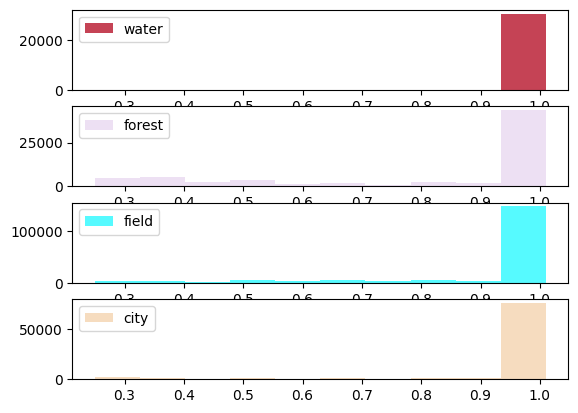

In [46]:
createHistGraph(proba1)

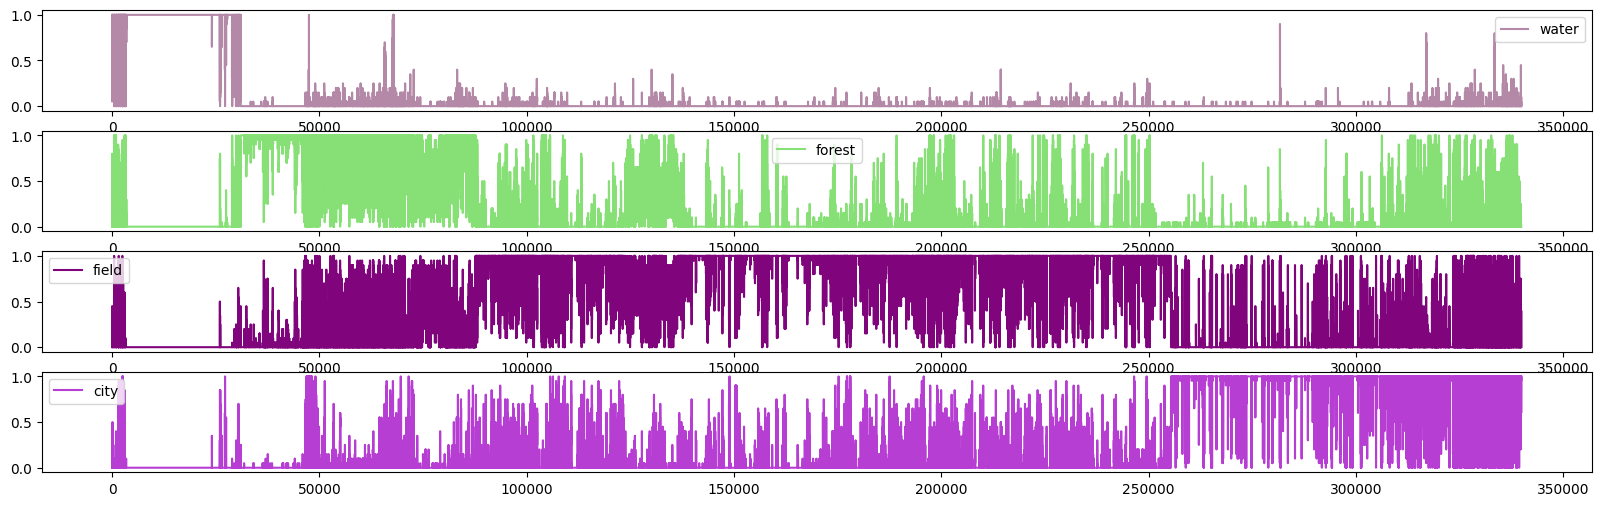

In [47]:
# fig1, axs1 = mplt.subplots(figsize=(20,6))
#
# for category in range(proba1.shape[1]):
#     plt.plot(list(range(x_test.shape[0])), proba1[:, category])
createProbalitiesCharts(proba1)

## SVM

In [48]:
# from sklearnex import patch_sklearn
#
# patch_sklearn()

from cuml.svm import SVC
svm = SVC(C=3.0, kernel='rbf', degree=6, cache_size=6096,probability=True)
svm.fit(x_train, y_train)

SVC()

In [49]:
svc_pred = svm.predict(x_test)

In [50]:
print(f"Accuracy: {accuracy_score(y_test, svc_pred)*100}")

Accuracy: 95.47107632554581


In [51]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99     31003
           2       0.95      0.85      0.90     56632
           3       0.94      0.98      0.96    167720
           4       0.98      0.95      0.97     84505

    accuracy                           0.95    339860
   macro avg       0.97      0.94      0.95    339860
weighted avg       0.96      0.95      0.95    339860



In [52]:
import pickle

knnModelFile = "/tmp/shared/svm_ds5.sav"

pickle.dump(svm, open(knnModelFile, 'wb'))

In [53]:
svc_proba = svm.predict_proba(x_test)

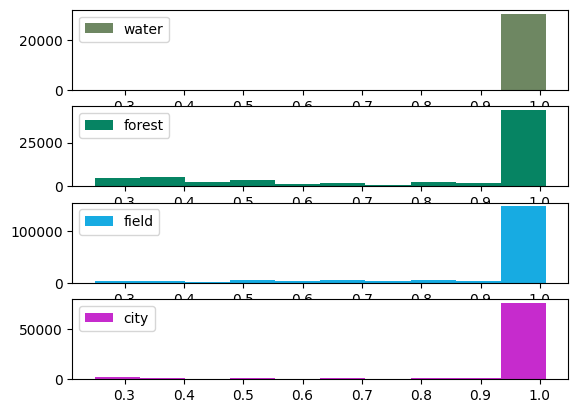

In [54]:
# import matplotlib.pyplot as mplt
#
# fig, axs = mplt.subplots(svc_proba.shape[1])
#
# # axs[0].hist(proba1[:, 0])
#
# for category in range(svc_proba.shape[1]):
#     col = (np.random.random(), np.random.random(), np.random.random())
#     axs[category].hist(svc_proba[:, category], color=col)
createHistGraph(svc_proba)

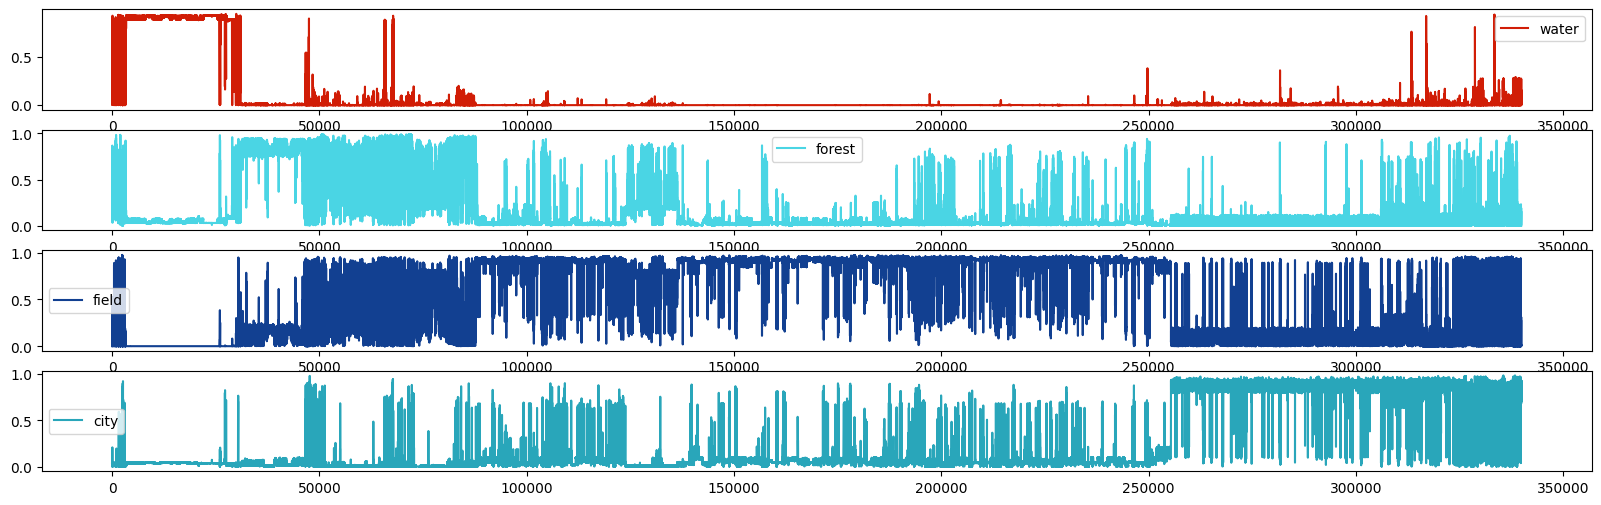

In [55]:
# fig1, axs1 = mplt.subplots(figsize=(20,6))
#
# for category in range(svc_proba.shape[1]):
#     plt.plot(list(range(x_test.shape[0])), svc_proba[:, category])
createProbalitiesCharts(svc_proba)

## Naive Bayes

In [56]:
from cuml.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
mnb = GaussianNB()
mnb_res = mnb.fit(x_train, y_train)

In [57]:
mnb_pred = mnb.predict(x_test)

In [58]:
print(f"Accuracy: {accuracy_score(y_test, svc_pred)*100}")

Accuracy: 95.47107632554581


In [59]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99     31003
           2       0.95      0.85      0.90     56632
           3       0.94      0.98      0.96    167720
           4       0.98      0.95      0.97     84505

    accuracy                           0.95    339860
   macro avg       0.97      0.94      0.95    339860
weighted avg       0.96      0.95      0.95    339860



In [60]:
import pickle

knnModelFile = "/tmp/shared/nb_ds5.sav"

pickle.dump(mnb, open(knnModelFile, 'wb'))

In [61]:
mnb_proba = mnb.predict_proba(x_test)

In [234]:
mnb_proba.shape

(133140, 3)

In [76]:
mnb_proba[:, 0]

array([1.        , 1.        , 0.99999575, ..., 0.16567062, 0.08714512,
       0.29588461])

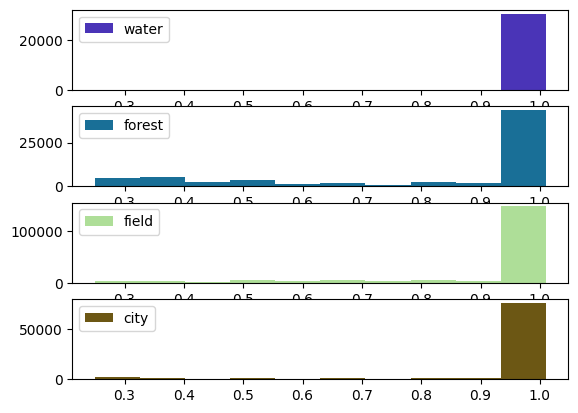

In [62]:
# import matplotlib.pyplot as mplt
#
# fig, axs = mplt.subplots(mnb_proba.shape[1])
#
# # axs[0].hist(mnb_proba[:, 0])
#
# for category in range(mnb_proba.shape[1]):
#     col = (np.random.random(), np.random.random(), np.random.random())
#     axs[category].hist(mnb_proba[:, category], color=col)
createHistGraph(mnb_proba)

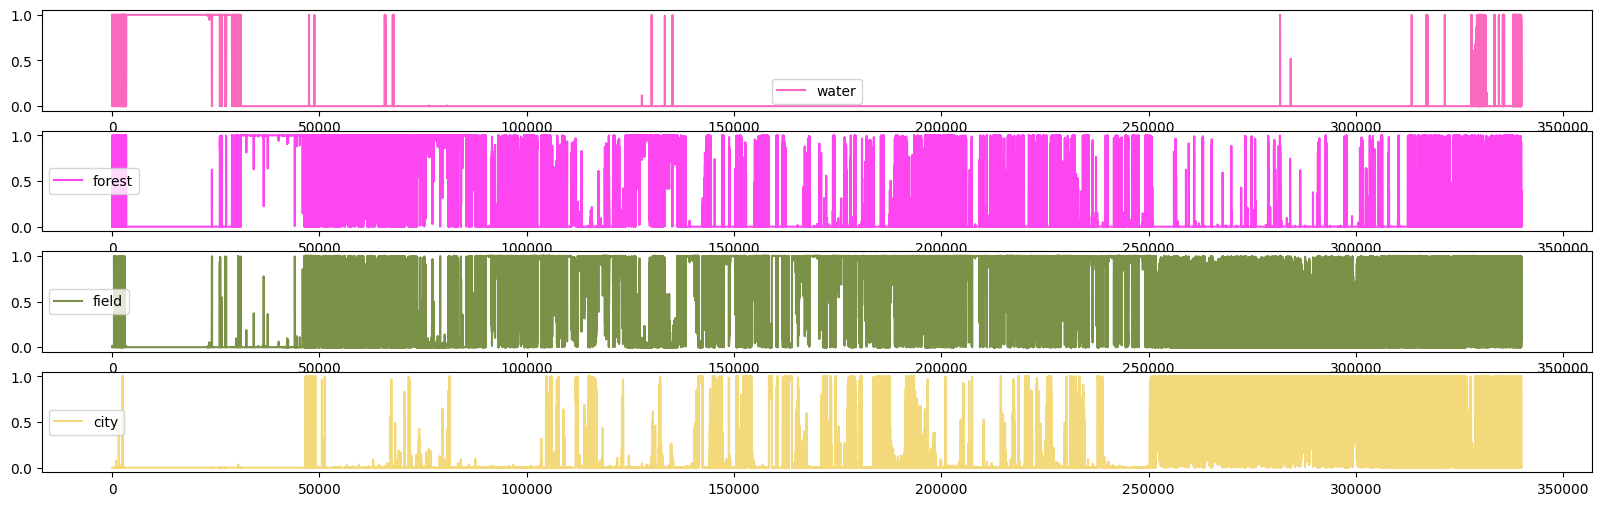

In [63]:
# fig1, axs1 = mplt.subplots(figsize=(20,6))
#
# for category in range(mnb_proba.shape[1]):
#     plt.plot(list(range(x_test.shape[0])), mnb_proba[:, category])
createProbalitiesCharts(mnb_proba)

# Test image

In [64]:
test_image_bands = glob("/tmp/shared/dataset4/2/*B?*.tiff")
test_image_bands.sort()
test_image_bands

['/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '/tmp/shared/dataset4/2/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B12_(Raw).tiff',

In [65]:
l2 = []
for i in test_image_bands:
  with rio.open(i, 'r') as f:
    l2.append(f.read(1))

In [66]:
arr_st2 = np.stack(l2)

In [54]:
arr_st2.shape

(12, 694, 1051)

In [67]:
def flattenTestImage(image):
    imgs = []
    for img in l2:
        imgs.append(list(itertools.chain(*img)))
    return imgs

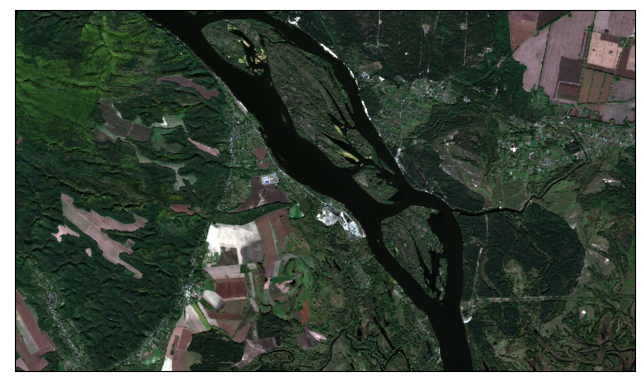

In [68]:
ep.plot_rgb(
    arr_st2,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

In [69]:
tst_img = flattenTestImage(l2)
tst_img_np = np.asarray(tst_img)
tst_img_np.shape
tst_img_np = np.moveaxis(tst_img_np, -1, 0)
# x2 = np.moveaxis(arr_st2, 0, -1)
# x2.shape

In [70]:
# X_data2 = x2.reshape(-1, 12)

# scaler2 = StandardScaler().fit(tst_img_np)
#
# X_scaled2 = scaler2.transform(tst_img_np)
#
# X_scaled2.shape

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled2 = scaler.fit_transform(tst_img_np)

## KNNC

In [71]:
test_image_predict = knn.predict(X_scaled2)

In [134]:
im2_to_show = arr_st2[[3,2,1],:,:]
im2_to_show.shape

(12, 638, 1094)

(638, 1094, 3)


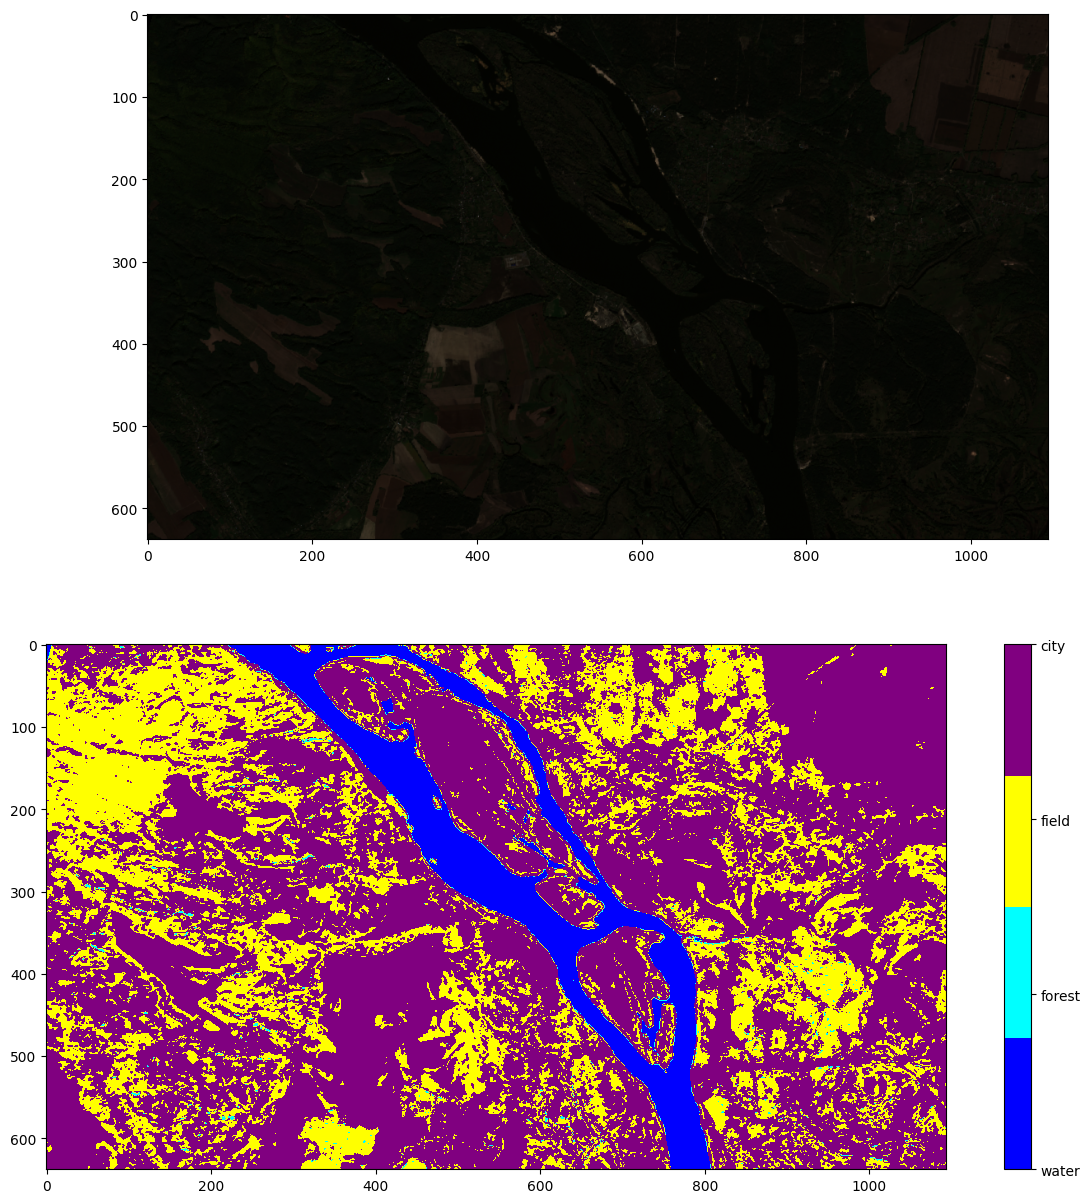

In [72]:
from PIL import Image

knn_image_default2 = test_image_predict.reshape(arr_st2[0].shape)
# ep.plot_rgb(
#     arr_st2,
#     rgb=(3, 2, 1),
#     # title="RGB Composite Image with Stretch Applied",
# )
# img = np.asarray(Image.open('/tmp/shared/dataset4/27/2022-11-08-00_00_2022-11-08-23_59_Sentinel-2_L2A_Highlight_Optimized_Natural_Color.tiff'))
# plt.imshow(img)
# ep.plot_bands(knn_image_default2, vmin=1,
#               cmap=ListedColormap(['blue', 'yellow', 'purple']))

fig, ax = plt.subplots(2,figsize=(15, 15))

im2_to_show = arr_st2[[3,2,1], :,:]
im2_to_show2 = np.moveaxis(im2_to_show, 0,-1)

print(im2_to_show2.shape)

im2 = ax[0].imshow(im2_to_show2)

im1 = ax[1].imshow(knn_image_default2,cmap=ListedColormap(['blue','cyan', 'yellow', 'purple']))
labels = list(categories_map.keys())
values = list(categories_map.values())

# Create a colorbar with the legend
colorbar = fig.colorbar(im1, ticks=values)
colorbar.ax.set_yticklabels(labels)
plt.show()

In [73]:
test_image_predict_knnc_proba = knn.predict_proba(X_scaled2)

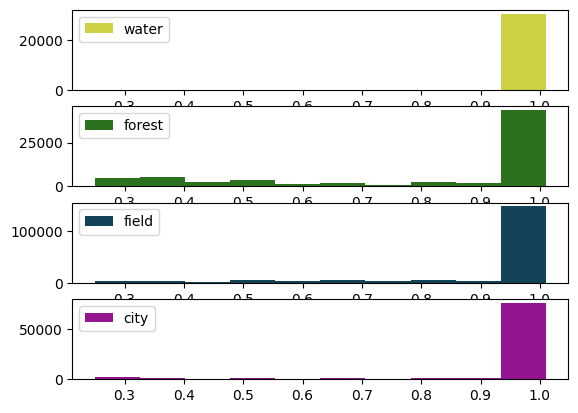

In [74]:
# import matplotlib.pyplot as mplt
#
# fig, axs = mplt.subplots(test_image_predict_knnc_proba.shape[1])
#
# # axs[0].hist(mnb_proba[:, 0])
#
# for category in range(test_image_predict_knnc_proba.shape[1]):
#     col = (np.random.random(), np.random.random(), np.random.random())
#     axs[category].hist(test_image_predict_knnc_proba[:, category], color=col)
createHistGraph(test_image_predict_knnc_proba)

## SVM

In [75]:
test_image_predict_svm = svm.predict(X_scaled2)

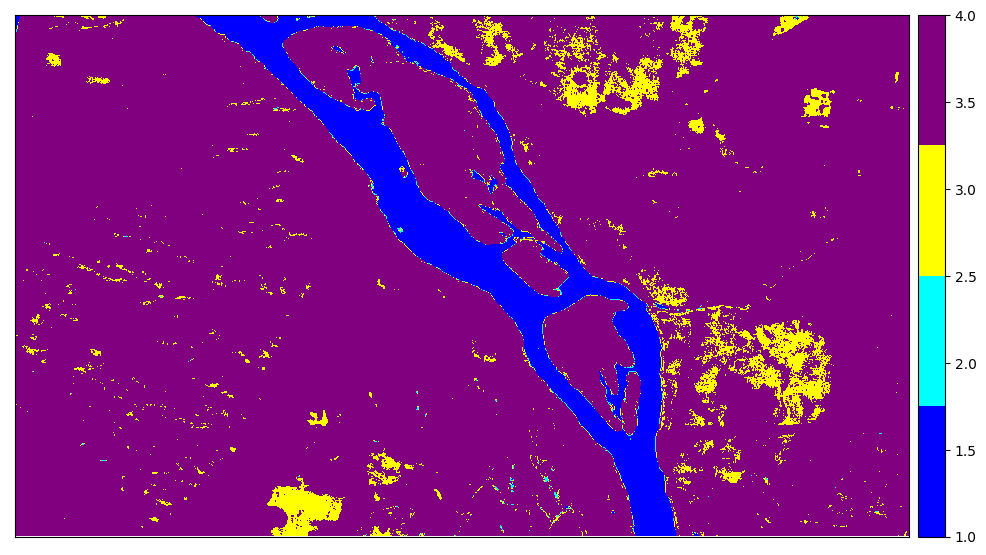

In [77]:
svm_image_default2 = test_image_predict_svm.reshape(arr_st2[0].shape)
ep.plot_bands(svm_image_default2, vmin=1,
              cmap=ListedColormap(['blue','cyan', 'yellow', 'purple']))
plt.show()

In [78]:
test_image_predict_svm_proba = svm.predict_proba(X_scaled2)

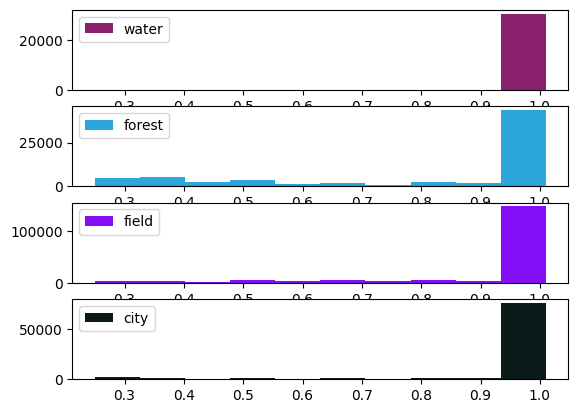

In [79]:
# import matplotlib.pyplot as mplt
#
# fig, axs = mplt.subplots(test_image_predict_svm_proba.shape[1])
#
# # axs[0].hist(mnb_proba[:, 0])
#
# for category in range(test_image_predict_svm_proba.shape[1]):
#     col = (np.random.random(), np.random.random(), np.random.random())
#     axs[category].hist(test_image_predict_svm_proba[:, category], color=col)
createHistGraph(test_image_predict_svm_proba)

## NB

In [80]:
test_image_predict_nb = mnb.predict(X_scaled2)

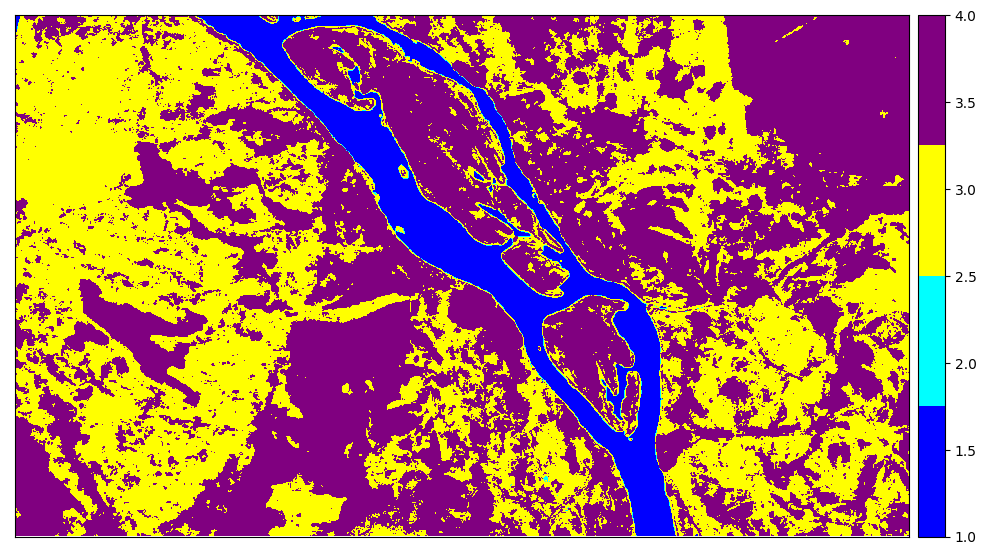

In [82]:
nb_image_default2 = test_image_predict_nb.reshape((638, 1094))
ep.plot_bands(nb_image_default2, vmin=1,
              cmap=ListedColormap(['blue','cyan', 'yellow', 'purple']))
plt.show()

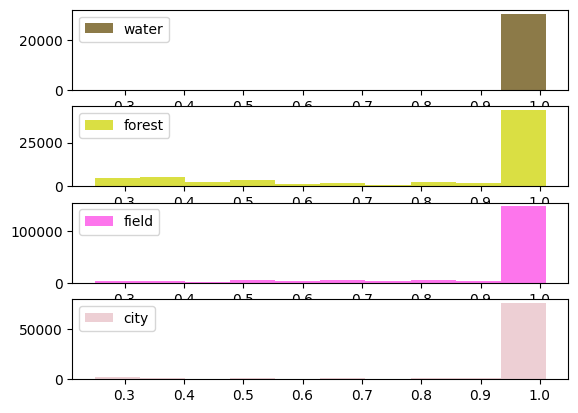

In [83]:
test_image_predict_nb_proba = mnb.predict_proba(X_scaled2)
createHistGraph(test_image_predict_nb_proba)

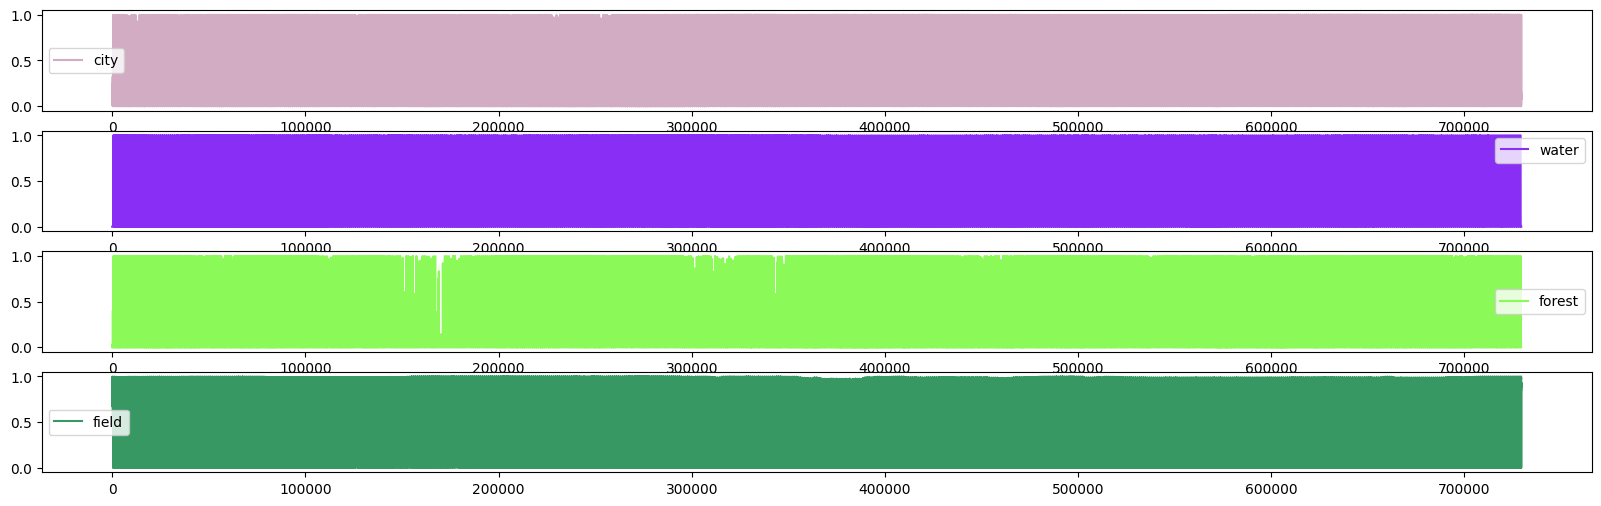

In [85]:
createProbalitiesCharts(test_image_predict_nb_proba)